In [1]:
# Step 1: Libraries import karo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

In [2]:
# Step 2: Dataset load karo
import tensorflow_datasets as tfds

In [3]:
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)
train_dataset = dataset['train']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.XL7ENF_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
print(f"Total images: {info.splits['train'].num_examples}")
print(f"Classes: {info.features['label'].names}")

Total images: 3670
Classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [5]:
# Step 3: Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20  # Kam epochs rakhe fast training ke liye
NUM_CLASSES = 5

In [6]:
# Step 4: Preprocessing function (simple - no augmentation)
def preprocess_image(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image, label

In [7]:
# Step 5: Dataset split karo
DATASET_SIZE = info.splits['train'].num_examples
train_size = int(0.8 * DATASET_SIZE)

In [9]:
train_size

2936

In [10]:
train_ds = train_dataset.take(train_size)
val_ds = train_dataset.skip(train_size)

In [13]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
val_ds

<_SkipDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
# Preprocessing apply karo
train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)


In [16]:
# Batching
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [17]:
# Step 6: VGG-16 Model banao
print("\n=== Building VGG-16 Model ===")
model = keras.Sequential()
# Block 1
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
# Block 2
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
# Block 3
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
# Block 4
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
# Block 5
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
# Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Model summary
model.summary()


=== Building VGG-16 Model ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,281,029 (512.24 MB)

 Trainable params: 134,281,029 (512.24 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Step 7: Model compile karo
print("\n=== Compiling Model ===")
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])


=== Compiling Model ===


In [19]:
# Step 8: Simple training - NO CALLBACKS
print("\n=== Training Started ===")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

print("\n=== Training Completed! ===")


=== Training Started ===
Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.2555 - loss: 1.6040 - val_accuracy: 0.2153 - val_loss: 1.6185
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 567ms/step - accuracy: 0.2507 - loss: 1.5978 - val_accuracy: 0.2153 - val_loss: 1.6145
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 52s 562ms/step - accuracy: 0.2614 - loss: 1.5951 - val_accuracy: 0.2153 - val_loss: 1.6082
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 52s 556ms/step - accuracy: 0.2614 - loss: 1.5840 - val_accuracy: 0.1989 - val_loss: 1.6328
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 52s 556ms/step - accuracy: 0.2602 - loss: 1.5772 - val_accuracy: 0.3501 - val_loss: 1.4897
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 52s 555ms/step - accuracy: 0.3279 - loss: 1.4732 - val_accuracy: 0.3665 - val_loss: 1.4151
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 553ms/step - accuracy: 0.3663 - loss: 1.4473 - val_accuracy: 0.3774 - val_loss: 1.4260
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 555ms/step - accuracy: 0.3632 -

Training plot saved!


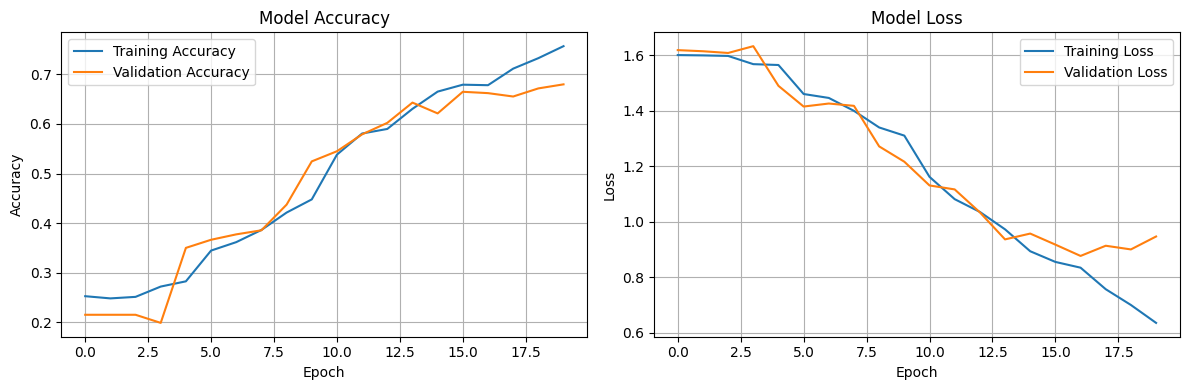

In [20]:
# Step 9: Training history plot karo
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('vgg16_simple_training.png')
print("Training plot saved!")
plt.show()

In [21]:
# Step 10: Final evaluation
print("\n=== Model Evaluation ===")
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")


=== Model Evaluation ===
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.6715 - loss: 0.9775
Validation Accuracy: 67.98%


In [22]:
# Step 11: Model ko save karo
print("\n=== Saving Model ===")
model.save('vgg16_flower_model.h5')
print("Model saved as 'vgg16_flower_model.h5'")


=== Saving Model ===
Model saved as 'vgg16_flower_model.h5'


In [ ]:
# Step 12: Validation dataset se prediction
print("\n=== Testing on Validation Data ===")
for images, labels in val_ds.take(1):
    predictions = model.predict(images[:3])
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = labels[:3].numpy()

    class_names = info.features['label'].names

    # Visualize predictions
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Predicted: {class_names[predicted_classes[i]]}\nActual: {class_names[actual_classes[i]]}\nConfidence: {predictions[i][predicted_classes[i]]:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('validation_predictions.png')
    print("Validation predictions saved!")
    plt.show()

In [27]:
# Step 13: NEW IMAGE PREDICTION - Internet se image download karke predict karo
print("\n=== Predicting on New Image from Internet ===")

# Example: Rose flower image URL (tum apni image ka URL dal sakte ho)
image_url = "https://radhakrishnaagriculture.in/products/tulip-imported-flower-bulbs-purple"


=== Predicting on New Image from Internet ===


In [28]:
try:
    # Image download karo
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # Image ko RGB mein convert karo (agar grayscale hai to)
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Original image dikhao
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Downloaded Image')
    plt.axis('off')

    # Preprocessing karo
    img_array = np.array(img)
    img_resized = tf.image.resize(img_array, [IMG_SIZE, IMG_SIZE])
    img_normalized = img_resized / 255.0
    img_batch = np.expand_dims(img_normalized, axis=0)  # Batch dimension add karo

    # Prediction karo
    prediction = model.predict(img_batch)
    predicted_class = np.argmax(prediction, axis=0)[0]
    confidence = prediction[0][predicted_class]

    class_names = info.features['label'].names

    # Result dikhao
    plt.subplot(1, 2, 2)
    plt.imshow(img_resized.numpy().astype('uint8'))
    plt.title(f"Prediction: {class_names[predicted_class]}\nConfidence: {confidence:.2f}")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('new_image_prediction.png')
    print(f"\nPredicted Class: {class_names[predicted_class]}")
    print(f"Confidence: {confidence*100:.2f}%")
    print("\nAll class probabilities:")
    for i, prob in enumerate(prediction[0]):
        print(f"  {class_names[i]}: {prob*100:.2f}%")

    plt.show()

except Exception as e:
    print(f"Error downloading image: {e}")
    print("Tip: Apna flower image URL try karo!")


Error downloading image: cannot identify image file <_io.BytesIO object at 0x7c06a838ac50>
Tip: Apna flower image URL try karo!


In [24]:
# Step 14: LOCAL IMAGE se prediction (agar tumhare paas local file hai)
print("\n=== Predicting on Local Image (Optional) ===")
print("Agar tumhare paas local image file hai, to ye code use karo:")
# Local image load karo
local_image_path = '/content/tulip.jpg'  # Apna path dalo
img = Image.open(local_image_path)

if img.mode != 'RGB':
    img = img.convert('RGB')

# Preprocessing
img_array = np.array(img)
img_resized = tf.image.resize(img_array, [224, 224])
img_normalized = img_resized / 255.0
img_batch = np.expand_dims(img_normalized, axis=0)

# Prediction
prediction = model.predict(img_batch)
predicted_class = np.argmax(prediction)
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print(f"Predicted: {class_names[predicted_class]}")
print(f"Confidence: {prediction[0][predicted_class]*100:.2f}%")


print("\n=== Complete! ===")
print("\nSummary:")
print("✅ VGG-16 model trained (no callbacks)")
print("✅ Model saved as 'vgg16_flower_model.h5'")
print("✅ Validation data pe test kiya")
print("✅ Internet se new image download karke predict kiya")
print("\nTumhara model ready hai! 🎉")


=== Predicting on Local Image (Optional) ===
Agar tumhare paas local image file hai, to ye code use karo:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: roses
Confidence: 89.72%

=== Complete! ===

Summary:
✅ VGG-16 model trained (no callbacks)
✅ Model saved as 'vgg16_flower_model.h5'
✅ Validation data pe test kiya
✅ Internet se new image download karke predict kiya

Tumhara model ready hai! 🎉


In [ ]:
2936/32